# Summary:

Author: Utkarsh Mital, umital@lbl.gov

- This notebook presents the workflow employed for downscaling meteorological variables as described in section 3 of the accompanying manuscript.
- We demonstrate the workflow for precipitation (PPT).
- The accompanying data folder consists of all the data needed for the demonstration.

Note: Since PRISM data at 800 m resolution is a proprietary dataset which cannot be publicly distributed, we provide a downscaled data file (DOWNSCALED_PRISM_PPT_20191205.tif) which is upscaled to the 800 m resolution. We then downscale this newly generated upscaled file to 400 m resolution.

## Package imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rasterio as rio
from rasterio.warp import Resampling
import shapely
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

### Package versions

The script was tested using the following package versions.

In [2]:
### Check your versions in case there is an issue with any of the code cells.

print (np.__version__)
## 1.21.4

print (pd.__version__)
## 1.3.4

print (xr.__version__)
## 0.20.1

print (gpd.__version__)
## 0.10.2

print (shapely.__version__)
## 1.8.0

print (rio.__version__)
## 1.2.8

print (sns.__version__)
## 0.11.2

print (sklearn.__version__)
## 1.0.1

1.21.4
1.3.4
0.20.1
0.10.2
1.8.0
1.2.8
0.11.2
1.0.1


## Some helpful functions

In [3]:
def upscale (src_file_path, dest_file_path, upscale_factor=0.5):
    """ This function upscales a dataset.
    In the current context, upscaling refers to resampling to lower resolution/larger cell sizes.
    Note that upscaling can also be referred to as downsampling.
    src_file_path: path of the source dataset which will be upscaled
    dest_file_path: pile of the destintation where the upscaled dataset will be saved
    upscale_factor: multipicative factor by which the dataset size will be reduced
    Resampling based on https://rasterio.readthedocs.io/en/latest/topics/resampling.html
    """

    with rio.open(src_file_path) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.bilinear
        )

        ### scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

        out_meta = dataset.meta.copy()

        ### Update the metadata to write the upscaled dataset
        out_meta.update({"driver": "GTiff",
                         "height": data.shape[1],
                         "width": data.shape[2],
                         "transform": transform
                         }
                        )

        with rio.open(dest_file_path, "w", **out_meta) as dest:
            dest.write(data)

def get_Points_gdf(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf


def get_nearest_neighbors (this_date_string):
    """Take in a string value (this_date_string) which represents the date.
    Return nearest neighbor values (w_1 to w_10) for that date"""
    n_stations = top10_stations_df.shape[1]
    n_pixels = top10_stations_df.shape[0]
    date_index = Dates[Dates == this_date_string].index
    col_names = ['Station_' + str(index) for index in np.arange(n_stations)]
    nearest_neighbors = pd.DataFrame(index=np.arange(n_pixels), columns=col_names).astype('float32')
    for ind in np.arange(n_pixels):
        nearest_neighbors.iloc[ind,:] = Point_precip.loc[date_index,top10_stations_df.loc[ind,:]].values
    
    return nearest_neighbors

def unflatten_index(flat_ind, ncols):
    """Take in the index of a flattened array (row-wise) and return the row and column index of an unflattened array"""
    row_ind = flat_ind//ncols ## quotient
    col_ind = flat_ind%ncols ## remainder
    return (row_ind, col_ind)

def flatten_index (row_ind, col_ind, ncols):
    """Take in the row and column index and return the index of a flattened array that goes row-wise."""
    return row_ind*ncols + col_ind

def get_800_rowcols (scale, row_ind_sub800, col_ind_sub800):
    """Take in (row,col) index corresponding to a sub-800m (here, 400 m) grid, and return (row,col) index for 800m-res grid.
    The smaller grid is assumed to fit perfectly within the larger grid."""
    row_ind_800 = row_ind_sub800//scale
    col_ind_800 = col_ind_sub800//scale
    return (row_ind_800, col_ind_800)

def get_unflattened_800res_index (flattened_index_sub800, ncols_sub800, ncols_800, scale):
    ## Get the indices of row,col for the regular unflattened shape
    unflattened_ind_sub800 = unflatten_index(flattened_index_sub800, ncols_sub800)
    ## Get the indices of row,col for the 800m-res input
    unflattened_ind_800 = get_800_rowcols(scale, *unflattened_ind_sub800)
    ## Get the index corresponding to the flattened 800m-res file
    flattened_index_800 = flatten_index(*unflattened_ind_800, ncols_800)
    return flattened_index_800

def get_downscaling_features(Points_sub800_gdf, Features_topography_sub800_df, PRISM_800_upscaled_file, precip_corr):

    
    with rio.open(PRISM_800_upscaled_file) as src:
        ncols_800 = src.read(1).shape[1]
    
    ncols_sub800 = int(ncols_800*downscale_factor)
    parent_indices = get_unflattened_800res_index (Points_sub800_gdf.index, ncols_sub800, ncols_800, downscale_factor)
    precip_corr_sub800 = precip_corr.loc[parent_indices]
    precip_corr_sub800.reset_index(drop=True, inplace=True)
    Features_sub800_df = pd.merge(Features_topography_sub800_df, precip_corr_sub800, left_index=True, right_index=True)
    return Features_sub800_df


def get_smooth_value (row_ind,col_ind, noisy_PRISM, height, width):
    x_cell = ds_grid_x[row_ind,col_ind]
    y_cell = ds_grid_y[row_ind,col_ind]
    value_cell = noisy_PRISM[row_ind,col_ind]
    bottomrow_ind = min(row_ind + max_cells + 1, height)
    toprow_ind = max(row_ind - max_cells, 0)
    leftcol_ind = max(col_ind - max_cells, 0)
    rightcol_ind = min(col_ind + max_cells + 1, width)
    x_grid_trunc = ds_grid_x[toprow_ind:bottomrow_ind, leftcol_ind:rightcol_ind]
    y_grid_trunc = ds_grid_y[toprow_ind:bottomrow_ind, leftcol_ind:rightcol_ind]
    
    noisy_PRISM_trunc = noisy_PRISM[toprow_ind:bottomrow_ind, leftcol_ind:rightcol_ind]

    distances = euclidean_distances(np.array([x_cell, y_cell])[np.newaxis], np.array([x_grid_trunc.flatten(), y_grid_trunc.flatten()]).T).flatten()*downscale_res ##distance in kilometers
    distances = np.reshape(distances, x_grid_trunc.shape)
    neighbor_values = noisy_PRISM_trunc[np.logical_and(distances <= max_dist, distances > 0)]
    neighbor_distances = distances[np.logical_and(distances <= max_dist, distances > 0)]

    mean_abs_diff = np.mean(np.abs(value_cell - neighbor_values))
    mean_abs_diff_max = value_cell*0.04
    a = a_max if mean_abs_diff >= mean_abs_diff_max else a_max*mean_abs_diff/mean_abs_diff_max
    value_cell_smoothed = np.sum(neighbor_values/(neighbor_distances**a))/np.sum(1.0/(neighbor_distances**a))

    return value_cell_smoothed

### Specify file paths

In [4]:
### Downscaled precipitation file, dated 2019/12/05
sample_PRISM_400_file = 'data/DOWNSCALED_PRISM_PPT_20191205.tif'

### Digital elevation file (800 m resolution) clipped to the extent of East-Taylor subbasin
DEM_800_file = 'data/DEM_EastTaylor_800.tif'

### Digital elevation file (400 m resolution) clipped to the extent of East-Taylor subbasin
DEM_400_file = 'data/DEM_EastTaylor_400.tif'

### w_1 to w_10: Top ten nearest neighbors for each grid point.
top10_stations_file = 'data/Top10_corr_stations_pixels.csv'

### Daily precipitation data for all weather stations in Upper Colorado River Basin. Missing values are imputed
### using sequential imputation described in Mital et al. (2020). Scripts for imputation can be obtained
### from https://doi.org/10.15485/1766329
Point_precip_file = 'data/Imputed_GHCN_precip_2008_2019.csv'

### Upscale sample_PRISM_400_file to generate a PRISM_800 file

In [5]:
PRISM_800_upscaled_file = 'data/PRISM_PPT_UPSCALED_20191205.tif'
upscale(sample_PRISM_400_file, PRISM_800_upscaled_file)

### Read in data needed for calculating nearest neighbors ($w_1$ to $w_{10}$)

In [6]:
top10_stations_df = pd.read_csv(top10_stations_file)
Point_precip = pd.read_csv(Point_precip_file)

### We discard the last row since it corresponds to the date 2019/12/31. The end date of the dataset is 2019/12/30.
Point_precip = Point_precip[:-1]

### This start date for Point_precip (or date corresponding to the first row)
start_date = datetime.datetime.strptime('20080101',"%Y%m%d")

### number of days (n_days) in the dataset (or number of rows in Point_precip)
n_days = Point_precip.shape[0]

### Create a variable "Dates" that has all the dates corresponding to the dataset 
### (or dates corresponding to each row in Point_precip)
Dates = pd.Series([(start_date + datetime.timedelta(days=int(i))).strftime("%Y%m%d") for i in np.arange(n_days)])

### Static Input Features for training: Elevation and coordinates

In [7]:
Points_gdf = get_Points_gdf(PRISM_800_upscaled_file)

with rio.open(DEM_800_file) as src:
    elev = src.read(1).reshape(-1,1).flatten()
    
elev = pd.Series(elev, name='Elevation')

Features_df = pd.merge(elev, Points_gdf.loc[:,['Longitude','Latitude']], left_index=True, right_index=True)

### Static Input Features for downscaling: Elevation and coordinates

In [8]:
Points_sub800_gdf = get_Points_gdf(DEM_400_file)

with rio.open(DEM_400_file) as src:
    elev_sub800 = src.read(1).reshape(-1,1).flatten()


elev_sub800 = pd.Series(elev_sub800, name='Elevation')


Features_sub800_df = pd.merge(elev_sub800, Points_sub800_gdf.loc[:,['Longitude','Latitude']], 
                              left_index=True, right_index=True)

### Gradient smoothing parameters (for precipitation only; skip for temperature)
This follows the description in Daly et al. (2008)

In [9]:
downscale_res=400
downscale_factor = int(800/downscale_res)

with rio.open(PRISM_800_upscaled_file) as src:
    template_height = src.height
    template_width = src.width

ds_height = template_height*downscale_factor
ds_width = template_width*downscale_factor
ds_grid = np.meshgrid(range(ds_width), range(ds_height))
ds_grid_x = ds_grid[0]
ds_grid_y = ds_grid[1]
a_max = 4

max_dist = 8000
max_cells = int(max_dist/downscale_res)

### Get the complete feature space and labels for training

In [10]:
with rio.open(PRISM_800_upscaled_file) as src:
    Label_array = src.read(1).flatten()
    
nearest_neighbors = get_nearest_neighbors ('20191205')
Features_df = pd.merge(Features_df, nearest_neighbors, left_index=True, right_index=True)

### Train the random forest (RF) model

In [11]:
## Fit RF
rf = RandomForestRegressor(n_estimators = 500, min_samples_leaf = 1, n_jobs=-1)
rf.max_features = int(np.ceil(Features_df.shape[1]/3))
rf.fit(Features_df, Label_array)

RandomForestRegressor(max_features=5, n_estimators=500, n_jobs=-1)

### Get downscaling features and predict the downscaled precipitation

In [12]:
Features_sub800_df = get_downscaling_features(Points_sub800_gdf, Features_sub800_df, PRISM_800_upscaled_file, nearest_neighbors)
downscaled_precip = rf.predict(Features_sub800_df)
ds_precip_reshaped = np.reshape(downscaled_precip, (ds_height,ds_width))

### Gradient smoothing of downscaled precipitation (skip for temperature)

In [13]:
smooth_PRISM = [get_smooth_value(row_ind,col_ind, ds_precip_reshaped, ds_height, ds_width)
                for row_ind, col_ind in zip(ds_grid_y.flatten(), ds_grid_x.flatten())]
smooth_PRISM = np.reshape(smooth_PRISM, (ds_height, ds_width))

# Visualize the downscaled data

Text(0.5, 1.0, 'Original resolution (800 m)')

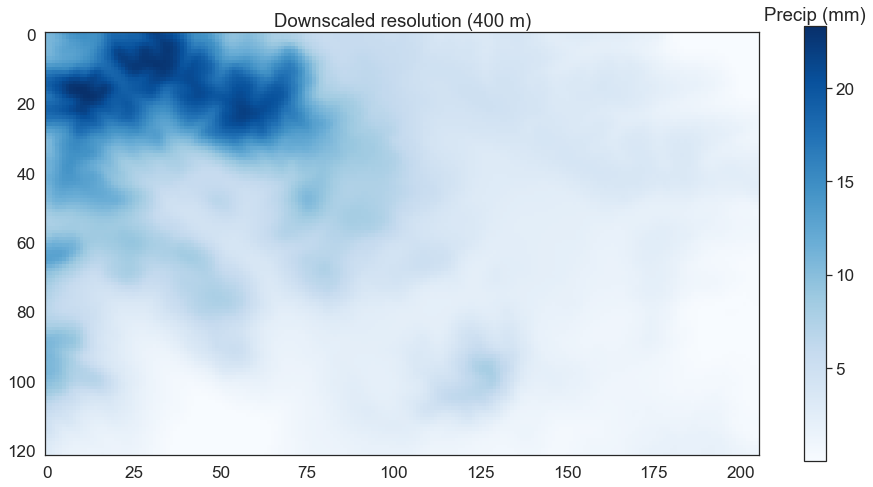

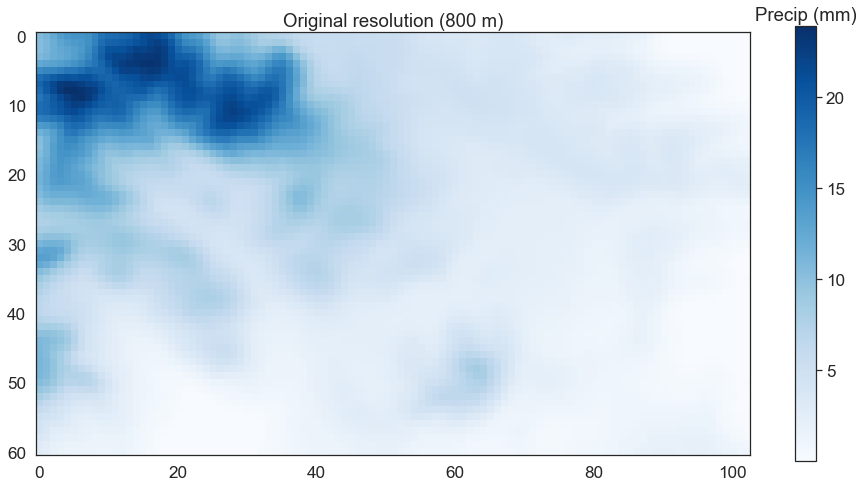

In [14]:
sns.set(font_scale=1.55, style='white')

fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(smooth_PRISM, cmap='Blues')
cbar = plt.colorbar(ax=ax)
cbar.ax.set_title('Precip (mm)')

plt.title('Downscaled resolution (400 m)')

fig, ax = plt.subplots(figsize=(16,8))
with rio.open(PRISM_800_upscaled_file) as src:
    plt.imshow(src.read(1), cmap='Blues')
cbar = plt.colorbar(ax=ax)
cbar.ax.set_title('Precip (mm)')
plt.title('Original resolution (800 m)')    